In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [2]:
#Unziping the dataset

!unzip -q "/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/Dataset.zip"

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

17235968/17225924 [==============================] - 0s 0us/step


In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [7]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704    
_________________________________________________________________
dense (Dense)                (None, 32)                1605664   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [9]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [12]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 1,
                  verbose = 1,
                  callbacks=lr_scheduler) 

129/129 [==============================] - 88s 430ms/step - loss: 1.0703 - accuracy: 0.7585 - precision: 0.5345 - recall: 0.2645 - auc: 0.7790 - val_loss: 1.1283 - val_accuracy: 0.7620 - val_precision: 0.5257 - val_recall: 0.4907 - val_auc: 0.8196


In [13]:
model.save_weights("/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile.hdf5")

In [14]:
weights_file=os.path.join("/content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile.hdf5")
 
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

callbacks= [checkpoint, lr_scheduler]

In [15]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 100,
                  verbose = 1,
                  callbacks=callbacks)

Epoch 1/100
129/129 [==============================] - 56s 431ms/step - loss: 1.0014 - accuracy: 0.7777 - precision: 0.6179 - recall: 0.2904 - auc: 0.8068 - val_loss: 0.9658 - val_accuracy: 0.7898 - val_precision: 0.6352 - val_recall: 0.3744 - val_auc: 0.8225

Epoch 00001: val_loss improved from inf to 0.96581, saving model to /content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile.hdf5
Epoch 2/100
129/129 [==============================] - 55s 429ms/step - loss: 0.9565 - accuracy: 0.7912 - precision: 0.6874 - recall: 0.3021 - auc: 0.8220 - val_loss: 0.9318 - val_accuracy: 0.7950 - val_precision: 0.6966 - val_recall: 0.3187 - val_auc: 0.8271

Epoch 00002: val_loss improved from 0.96581 to 0.93178, saving model to /content/drive/MyDrive/Garvin/IEEE/Alzheimer's Disease Classification/model_mobile.hdf5
Epoch 3/100
129/129 [==============================] - 54s 420ms/step - loss: 0.9371 - accuracy: 0.7937 - precision: 0.6834 - recall: 0.3255 - auc: 0.8316 - val_l

In [22]:
model.save('/content/drive/MyDrive/Garvin/IEEE/saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Garvin/IEEE/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Garvin/IEEE/saved_model/assets


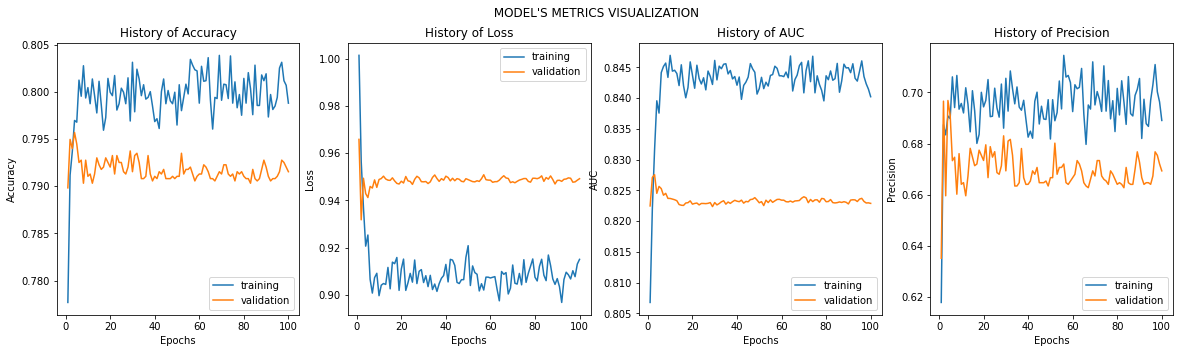

In [23]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
  
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              )

In [24]:
scores = model.evaluate(test_dataset)

40/40 [==============================] - 4s 89ms/step - loss: 0.9403 - accuracy: 0.7965 - precision: 0.6705 - recall: 0.3659 - auc: 0.8374


In [25]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])

Accuracy =  0.7965207099914551
Precision =  0.670487105846405
Recall =  0.3659108579158783
AUC =  0.837359607219696
